# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Reshape, MaxPooling2D, Flatten, Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2023-04-15 08:23:51.948574: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 08:23:51.950320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 08:23:51.985203: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 08:23:51.986028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 08:23:52.598522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np

from nebula.data.yg_ar.setup_data_image_hard import read_data
from nebula.common import to_scale_one, write_pickle, read_pickle
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import os
import os.path as osp
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
import plotly.io as pio
pio.renderers.default = "iframe"

import plotly.offline as pyo
pyo.init_notebook_mode()

from matplotlib.colors import BoundaryNorm, ListedColormap
import seaborn as sns
import shap


/home/ubuntu/.local/lib/python3.9/site-packages/numba/core/errors.py:175: UserWarning:

Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9



# Read data and apply label map

In [3]:
#  Correct
def create_label_map(labels):
    label_set = set()
    for lt in labels:
        label_set.add(lt)
    label_set = list(label_set)
    label_set.sort()
    label_map = {}
    count = 0
    for l in label_set:
        label_map[l] = count
        count += 1
    return label_map

In [4]:
# def create_label_map(labels):
#     label_set = set()
#     for lt in labels:
#         label_set.add(lt)

#     label_map = {}
#     count = 0
#     for l in label_set:
#         label_map[l] = count
#         count += 1
        
#     return label_map

In [5]:
df_path = "/home/ubuntu/data/yg_ar/image_hard_df.pkl"
random_seed = 1
df, train_df, test_df, valid_df = read_data(df_path, random_seed)

In [6]:
label_at_map = create_label_map(df["label_at"])
label_a_map = create_label_map(df["label_a"])


In [7]:
label_at_map

{'camel_1': 0,
 'camel_2': 1,
 'camel_3': 2,
 'camel_4': 3,
 'chair_1': 4,
 'chair_2': 5,
 'chair_3': 6,
 'chair_4': 7,
 'childs_1': 8,
 'childs_2': 9,
 'childs_3': 10,
 'childs_4': 11,
 'lord_of_the_dance_1': 12,
 'lord_of_the_dance_2': 13,
 'lord_of_the_dance_3': 14,
 'lord_of_the_dance_4': 15,
 'lotus_1': 16,
 'lotus_2': 17,
 'lotus_3': 18,
 'lotus_4': 19,
 'thunderbolt_1': 20,
 'thunderbolt_2': 21,
 'thunderbolt_3': 22,
 'thunderbolt_4': 23,
 'triangle_1': 24,
 'triangle_2': 25,
 'triangle_3': 26,
 'triangle_4': 27,
 'upward_dog_1': 28,
 'upward_dog_2': 29,
 'upward_dog_3': 30,
 'upward_dog_4': 31,
 'warrior_III_1': 32,
 'warrior_III_2': 33,
 'warrior_III_3': 34,
 'warrior_III_4': 35,
 'warrior_II_1': 36,
 'warrior_II_2': 37,
 'warrior_II_3': 38,
 'warrior_II_4': 39}

In [8]:
X_train = np.array([x for x in train_df.image])
y_train = train_df.label_at.map(label_at_map).to_list()

X_val = np.array([x for x in valid_df.image])
y_val = valid_df.label_at.map(label_at_map).to_list()

X_test = np.array([x for x in test_df.image])
y_test = test_df.label_at.map(label_at_map).to_list()

In [9]:
X_train = np.expand_dims(X_train,axis=3)
X_val = np.expand_dims(X_val,axis=3)
X_test = np.expand_dims(X_test,axis=3)

# Scale data

In [10]:
scaled_X_train = X_train/255.0 
scaled_X_val = X_val/255.0
scaled_X_test = X_test/255.0

# Test model

In [11]:
model = tf.keras.models.load_model('./big_model_for_coding.h5')

In [12]:
y_pred = np.argmax(model.predict(scaled_X_test),axis=1)
print(classification_report(y_test,y_pred,target_names = list(label_at_map.keys())))


68/68 [==============================] - 16s 235ms/step
                     precision    recall  f1-score   support

            camel_1       0.98      0.91      0.94        54
            camel_2       0.95      0.98      0.96        54
            camel_3       0.83      0.96      0.89        54
            camel_4       0.96      0.83      0.89        54
            chair_1       0.93      0.93      0.93        54
            chair_2       0.93      0.96      0.95        54
            chair_3       0.85      0.85      0.85        54
            chair_4       0.94      0.87      0.90        54
           childs_1       0.87      0.85      0.86        54
           childs_2       0.81      0.89      0.85        54
           childs_3       0.89      0.94      0.92        54
           childs_4       0.95      0.98      0.96        54
lord_of_the_dance_1       0.93      1.00      0.96        54
lord_of_the_dance_2       1.00      1.00      1.00        54
lord_of_the_dance_3       1.

In [13]:
test_df['y_pred'] = y_pred 
test_df['y_test'] = y_test

In [14]:
test_df['y_pred_mapped'] = test_df['y_pred'].map({v:k for k,v in label_at_map.items()})

In [15]:
test_df['y_pred_mapped_a_label'] = test_df['y_pred_mapped'].apply(lambda x: x[:-2]) 

# Confusion Matrix by a label

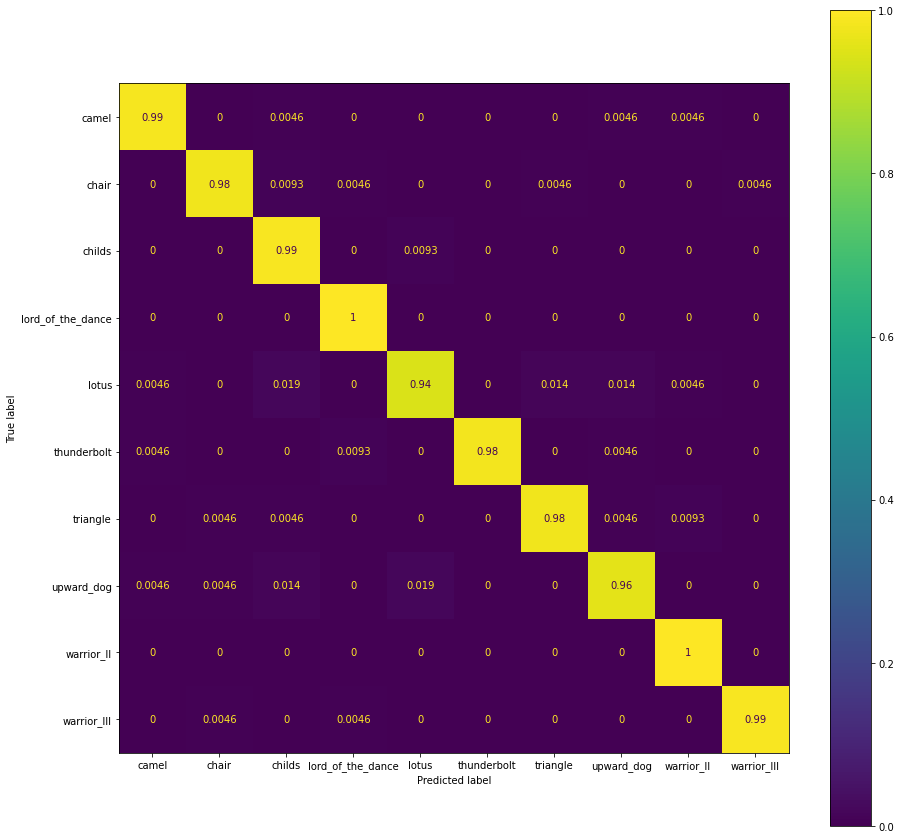

In [16]:
cm = confusion_matrix(test_df['label_a'],test_df['y_pred_mapped_a_label'],normalize='true')
fig, ax = plt.subplots(figsize=(15,15))
p = ConfusionMatrixDisplay(cm,display_labels=label_a_map.keys())
p.plot(ax = ax)
plt.show()

# Confusion Matrix by at label

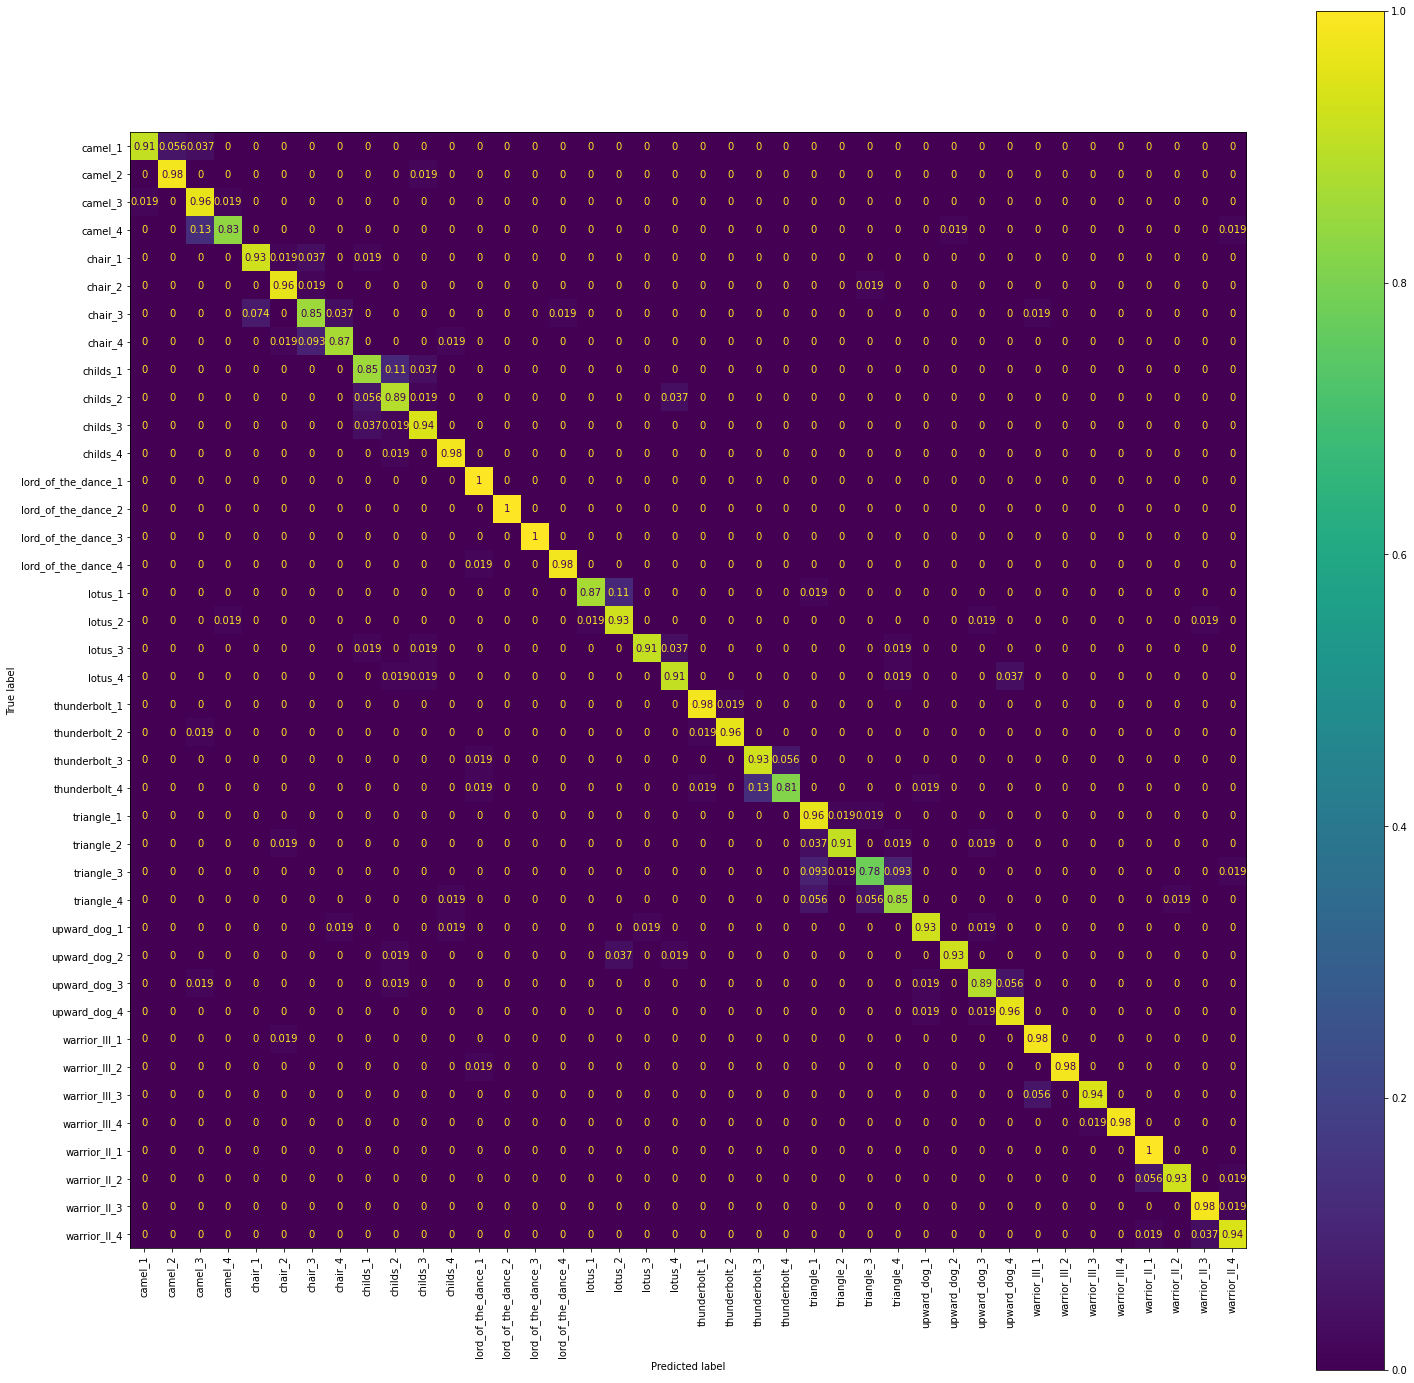

In [17]:
cm = confusion_matrix(test_df['label_at'],test_df['y_pred_mapped'],normalize='true')
fig, ax = plt.subplots(figsize=(25,25))
p = ConfusionMatrixDisplay(cm,display_labels=label_at_map.keys())
p.plot(ax = ax)
plt.xticks(rotation=90)
plt.show()

# Correct vs Error plots (based on class)

In [18]:
test_df['PREDICTED_CORRECT_CLASS'] = test_df['label_a'] == test_df['y_pred_mapped_a_label']

In [19]:
test_correct_prediction_df = test_df[test_df['PREDICTED_CORRECT_CLASS']]
test_incorrect_prediction_df = test_df[~test_df['PREDICTED_CORRECT_CLASS']]

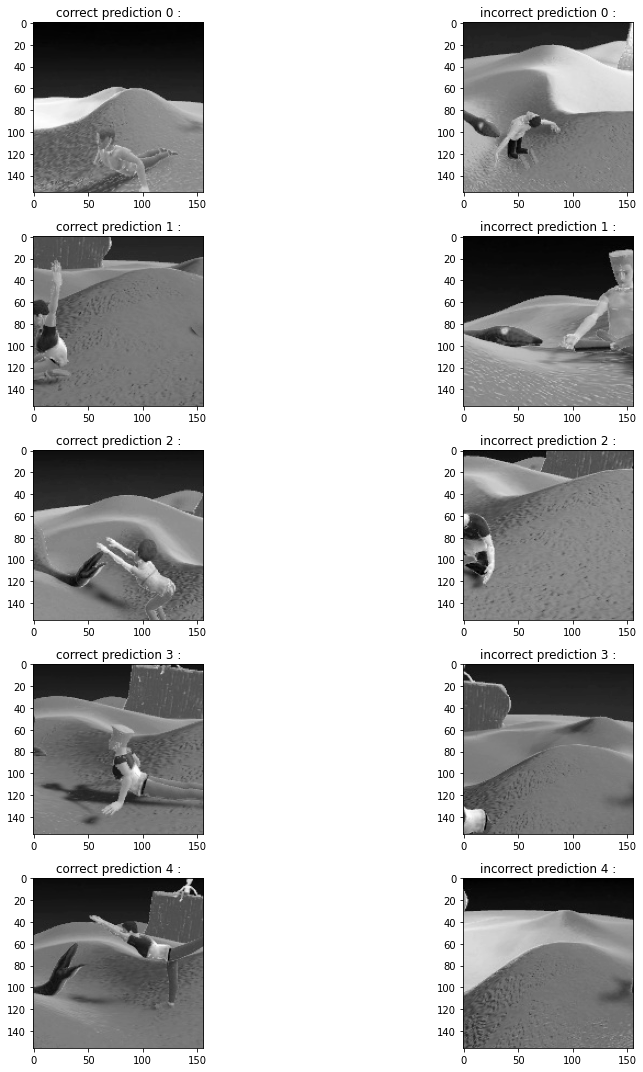

In [20]:
n_samples_to_examine = 5

correct_predictions_index = random.sample(range(len(test_correct_prediction_df)), n_samples_to_examine)
incorrect_predictions_index = random.sample(range(len(test_incorrect_prediction_df)), n_samples_to_examine)

fig, axs = plt.subplots(n_samples_to_examine, 2,figsize=(15,15))
for i in range(n_samples_to_examine):    
    axs[i, 0].imshow(test_correct_prediction_df['image'].iloc[correct_predictions_index[i]].reshape(156,156),cmap='gray')
    axs[i, 0].set_title("correct prediction "+str(i)+" :")
for i in range(n_samples_to_examine):    
    axs[i, 1].imshow(test_incorrect_prediction_df['image'].iloc[incorrect_predictions_index[i]].reshape(156,156),cmap='gray')
    axs[i, 1].set_title("incorrect prediction "+str(i)+" :")

fig.tight_layout()

In [21]:
test_df.head(2)

image     label_a  \
18004  [[36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, ...  warrior_II   
18330  [[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, ...  warrior_II   

           label_at                                          file_name  \
18004  warrior_II_1  warrior_II_1_hair_0_cloth_1_pants_0_Z1097_XON1...   
18330  warrior_II_1  warrior_II_1_hair_2_cloth_2_pants_3_Z1127_XON4...   

       y_pred  y_test y_pred_mapped y_pred_mapped_a_label  \
18004      36      36  warrior_II_1            warrior_II   
18330      36      36  warrior_II_1            warrior_II   

       PREDICTED_CORRECT_CLASS  
18004                     True  
18330                     True

# Correct vs Error plots (based on class and type)

In [22]:
test_df['PREDICTED_CORRECT_TYPE'] = test_df['label_at'] == test_df['y_pred_mapped']

In [23]:
test_correct_prediction_df = test_df[test_df['PREDICTED_CORRECT_TYPE']]
test_incorrect_prediction_df = test_df[~test_df['PREDICTED_CORRECT_TYPE']]

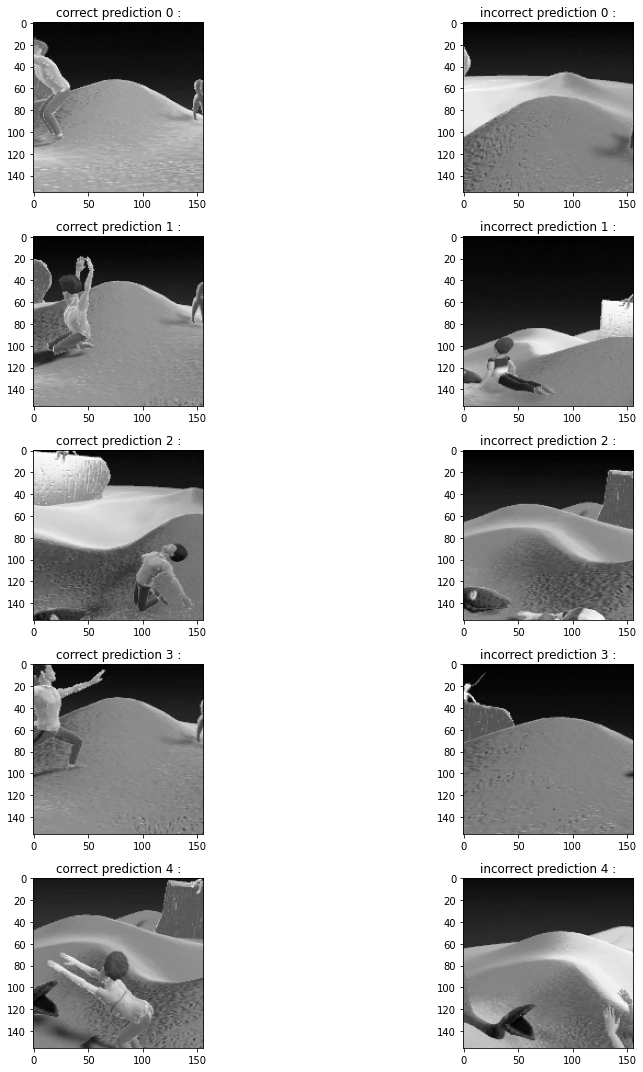

In [24]:
n_samples_to_examine = 5

correct_predictions_index = random.sample(range(len(test_correct_prediction_df)), n_samples_to_examine)
incorrect_predictions_index = random.sample(range(len(test_incorrect_prediction_df)), n_samples_to_examine)

fig, axs = plt.subplots(n_samples_to_examine, 2, figsize=(15,15))
for i in range(n_samples_to_examine):    
    axs[i, 0].imshow(test_correct_prediction_df['image'].iloc[correct_predictions_index[i]].reshape(156,156),cmap='gray')
    axs[i, 0].set_title("correct prediction "+str(i)+" :")
for i in range(n_samples_to_examine):    
    axs[i, 1].imshow(test_incorrect_prediction_df['image'].iloc[incorrect_predictions_index[i]].reshape(156,156),cmap='gray')
    axs[i, 1].set_title("incorrect prediction "+str(i)+" :")

fig.tight_layout()

# Error by categories

## process file info

In [25]:
def parse_filename(filename):
    words = filename.split("_")
    
    yangle = words[-1]
    yangle_val = float(yangle[3:]) / 10
    if yangle[2] == "N":
        yangle_val = -yangle_val
        
    xangle = words[-2]
    xangle_val = float(xangle[3:]) / 10
    if xangle[2] == "N":
        xangle_val = -xangle_val
        
    yoffset = words[-3]
    yoffset_val = float(yoffset[3:]) / 10
    if yoffset[2] == "N":
        yoffset_val = -yoffset_val
    
    xoffset = words[-4]
    xoffset_val = float(xoffset[3:]) / 10
    if xoffset[2] == "N":
        xoffset_val = -xoffset_val
        
    zoom = words[-5]
    zoom_val = float(zoom[1:]) / 10
    
    pants_type = words[-6]
    cloth_type = words[-8]
    hair_type = words[-10]
    
    action_type = words[-12]
    
    action = "_".join(words[:-12])
    
    return action, action_type, hair_type, cloth_type, pants_type, zoom_val, xoffset_val, yoffset_val, xangle_val, yangle_val
    
    

In [26]:
all_file_info = ['hair_type', 'cloth_type', 'pants_type', 'zoom_val', 'xoffset_val', 'yoffset_val', 'xangle_val', 'yangle_val']

In [27]:
test_df['tmp_file_info'] = test_df.file_name.apply(parse_filename)

In [28]:
for i, c in enumerate(all_file_info):
    test_df[c] = test_df['tmp_file_info'].apply(lambda x: x[i+2])

In [29]:
# zoom - 70.0, 120.0
bins = [70,80,90,100,110,120]
labels = [70,80,90,100,110]
test_df['binned_zoom_val'] = pd.cut(test_df['zoom_val'], bins=bins, labels=labels)

# xoffset - -3.0, 3.0
bins = [-3.0,-2.0,-1.0,0,1.0,2.0,3.0]
labels = [-3.0,-2.0,-1.0,0,1.0,2.0]
test_df['binned_xoffset_val'] = pd.cut(test_df['xoffset_val'], bins=bins, labels=labels)

# yoffset - -2.0, 2.0
bins = [-2.0,-1.0,0,1.0,2.0]
labels = [-2.0,-1.0,0,1.0]
test_df['binned_yoffset_val'] = pd.cut(test_df['yoffset_val'], bins=bins, labels=labels)

# xangle - -5.0, 20.0
bins = [-5.0,0,5.0,10.0,15.0,20.0]
labels = [-5.0,0,5.0,10.0,15.0]
test_df['binned_xangle_val'] = pd.cut(test_df['xangle_val'], bins=bins, labels=labels)

# yangle - -45.0, 45.0
bins = [-45.0,-30.0,-15.0,0,15.0,30.0,45.0]
labels = [-45.0,-30.0,-15.0,0,15.0,30.0]
test_df['binned_yangle_val'] = pd.cut(test_df['yangle_val'], bins=bins, labels=labels)


In [31]:
outs = [widgets.Output() for i in all_file_info]
tab = widgets.Tab(children=outs)
for i,c in enumerate(all_file_info):
    tab.set_title(i, c)
display(tab)

for tab_i,c in enumerate(all_file_info):
    with outs[tab_i]:
        c = "binned_"+c if tab_i>=3 else c
        print(c)

        accuracy_df = (test_df.groupby(c).PREDICTED_CORRECT_TYPE.sum()*100.0/test_df.groupby(c).PREDICTED_CORRECT_TYPE.count()).reset_index()
        print(accuracy_df)
        
        # Plotly not working with tab for some weird reason!!!
        
        plt.figure()
        plt.bar(x = accuracy_df[c],height=accuracy_df['PREDICTED_CORRECT_TYPE'])
        plt.title('accuracy by '+c)
        plt.show()
        # fig = px.bar(accuracy_df,x=c,y='PREDICTED_CORRECT_TYPE',title='accuracy by '+c)
        # fig.update_layout(autosize=False,width=800,height=500)
        # fig.show()

# Visualize CNN

## Visualize filters

In [32]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d (3, 3, 1, 32)
conv2d_1 (3, 3, 32, 32)
conv2d_2 (3, 3, 32, 64)
conv2d_3 (3, 3, 64, 64)
conv2d_4 (3, 3, 64, 128)
conv2d_5 (3, 3, 128, 128)
conv2d_6 (3, 3, 128, 256)
conv2d_7 (3, 3, 256, 256)
conv2d_8 (3, 3, 256, 512)
conv2d_9 (3, 3, 512, 512)


In [33]:
my_colors = ['red','yellow','green']
bounds = [-10,0,10]

my_cmap = ListedColormap(my_colors)


layer_names = []
for layer in model.layers[1:]:
    if 'conv' in layer.name:
        layer_names.append(layer.name)
        
layer_names = ['conv2d']
outs = [widgets.Output() for i in layer_names]

tab = widgets.Tab(children=outs)
for i,c in enumerate(layer_names):
    tab.set_title(i,c)
    
display(tab)

fig_size_list = [15,28,48]

for tab_i, layer_name in enumerate(layer_names):
    with outs[tab_i]:
        filters, biases = model.get_layer(layer_name).get_weights()
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
        print(filters.shape)
        n_filters = filters.shape[-1]
        for i in range(n_filters):
            # get the filter
            print("Current Filter: ", i)
            f = filters[:,:,0,i]
            ax = sns.heatmap(f,square=True,annot=True,cmap=my_cmap)
            plt.show()

## Visualize feature maps

### conv2d

In [34]:
feature_model = Model(inputs=model.inputs , outputs=model.layers[0].output)
  
index_of_images_to_examine = random.sample(range(len(test_correct_prediction_df)), 5)


unscaled_image_arrays = X_test[index_of_images_to_examine]
image_arrays = scaled_X_test[index_of_images_to_examine]


In [35]:

outs = [widgets.Output() for i in image_arrays]

tab = widgets.Tab(children=outs)
for i,c in enumerate(image_arrays):
    tab.set_title(i,str(i))
    
display(tab)


for tab_i, image in enumerate(image_arrays):

    plt.imshow(unscaled_image_arrays[tab_i], cmap='gray')
    with outs[tab_i]:
        print(image.shape)
        image = np.expand_dims(image, axis=0)

        features = feature_model.predict(image)
        print("features shape: ",features.shape)

        fig = plt.figure(figsize=(20,15))

        for i in range(1,features.shape[3]+1):

            plt.subplot(8,4,i)
            plt.imshow(features[0,:,:,i-1] , cmap=my_cmap)
            
        plt.show()

### Other layers

In [36]:
all_conv_layer_names = [layer.name for layer in model.layers if 'conv' in layer.name][1:]
all_conv_layer_names

['conv2d_1',
 'conv2d_2',
 'conv2d_3',
 'conv2d_4',
 'conv2d_5',
 'conv2d_6',
 'conv2d_7',
 'conv2d_8',
 'conv2d_9']

In [37]:
outputs = [model.get_layer(layer_name).output for layer_name in all_conv_layer_names]

model2 = Model( inputs= model.inputs, outputs = outputs)

In [38]:

outs = [widgets.Output() for i in image_arrays]

tab = widgets.Tab(children=outs)
for i,c in enumerate(image_arrays):
    tab.set_title(i,str(i))
    
display(tab)


for tab_i, image in enumerate(image_arrays):

    plt.imshow(unscaled_image_arrays[tab_i], cmap='gray')
    with outs[tab_i]:
        print(image.shape)
        image = np.expand_dims(image, axis=0)

        feature_map = model2.predict(image)

        for layer_name,fmap in zip(all_conv_layer_names,feature_map):
            fig = plt.figure(figsize=(20,15))
            fig.suptitle(layer_name , fontsize=20)
            for i in range(1,features.shape[3]+1):

                plt.subplot(8,8,i)
                plt.imshow(fmap[0,:,:,i-1] , cmap=my_cmap)

        plt.show()
        
        


# Shap Analysis

In [39]:
background = scaled_X_train[np.random.choice(scaled_X_train.shape[0], 10, replace=False)]

shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough

e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)



keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [40]:
shap_values = e.shap_values(image_arrays)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    File "/home/ubuntu/.local/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py", line 252, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_BatchMatMulV2


In [41]:
# outs = [widgets.Output() for i in list(label_at_map.keys())]

# tab = widgets.Tab(children=outs)
# for i,c in enumerate(list(label_at_map.keys())):
#     tab.set_title(i,c)
    
# display(tab)


# for tab_i, image in enumerate(list(label_at_map.keys())):

#     with outs[tab_i]:
#         fig = plt.figure(figsize=(20,20))
#         shap.image_plot(shap_values[tab_i], -image_arrays, show=False)
#         plt.show()

        

In [42]:
test_df.iloc[index_of_images_to_examine].label_at

19615     warrior_II_4
4503          childs_2
15229     upward_dog_3
18722     warrior_II_2
11396    thunderbolt_3
Name: label_at, dtype: object

In [43]:
from IPython.display import display, clear_output


w = widgets.Dropdown(
    options=list(label_at_map.keys()),
    value = list(label_at_map.keys())[0],
    description='Class',
)
out = widgets.Output()

display(w,out)

def on_change(c):

    with out:

        if (c['type'] == 'change' and c['name'] == 'value'):
            clear_output()
            # display(w)
            tab_i = list(label_at_map.keys()).index(c['new'])
            fig = plt.figure(figsize=(20,20))
            shap.image_plot(shap_values[tab_i], -image_arrays, show=False)
            plt.show()

w.observe(on_change)

Dropdown(description='Class', options=('camel_1', 'camel_2', 'camel_3', 'camel_4', 'chair_1', 'chair_2', 'chai…

Output()